In [1]:
import keras as K
import tensorflow as tf
import cv2     # for capturing videos
import math   # for mathematical operations
from tqdm import tqdm
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from keras.preprocessing.image import ImageDataGenerator
import gc
import os

from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Input, LSTM, Subtract

from keras.models import Model

from keras.applications.vgg16 import VGG16


In [2]:
def get_siamese_network(input_shape):
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    VGG = VGG16(weights='imagenet', include_top=False)
    
    for layer in VGG.layers[:10]:
        layer.trainable=False
    
    for layer in VGG.layers:
        sp='     '
        print(layer.name, sp, layer.trainable)

    left_encode = VGG(left_input)
    right_encode = VGG(right_input)
    
    net = Subtract()([left_encode, right_encode])
    net = Flatten()(net)
    net = Dense(128, activation='relu')(net)
    output = Dense(1, activation='linear')(net)
      
    siamese_net = Model(inputs=[left_input, right_input], outputs=output)
    
    return(siamese_net)
    

In [3]:
model = get_siamese_network([480, 640, 3])

model.summary()
model.compile(optimizer='Adam', loss='mean_squared_error')


58892288/58889256 [==============================] - 1s 0us/step
input_3       False
block1_conv1       False
block1_conv2       False
block1_pool       False
block2_conv1       False
block2_conv2       False
block2_pool       False
block3_conv1       False
block3_conv2       False
block3_conv3       False
block3_pool       True
block4_conv1       True
block4_conv2       True
block4_conv3       True
block4_pool       True
block5_conv1       True
block5_conv2       True
block5_conv3       True
block5_pool       True
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 480, 640, 3) 0              

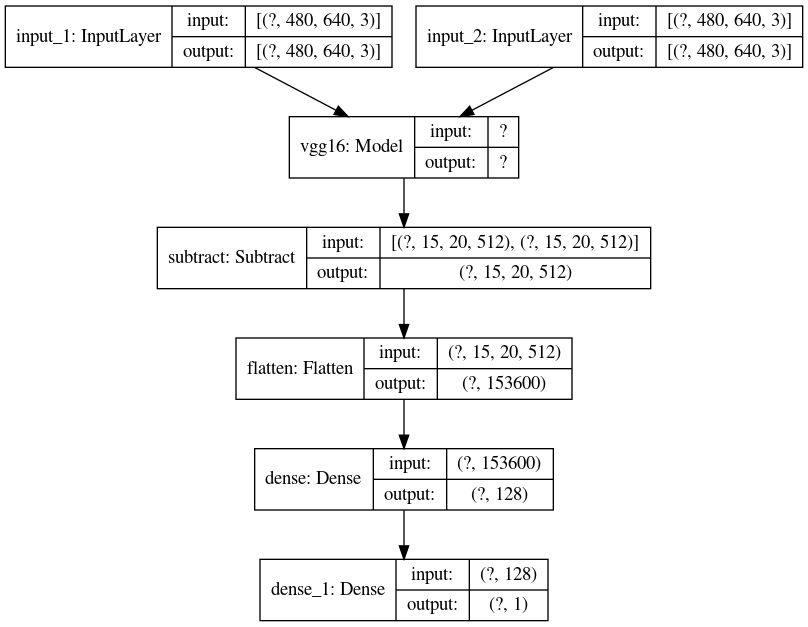

In [4]:
K.utils.plot_model(model, to_file="model.png", show_shapes=True)


(480, 640, 3)


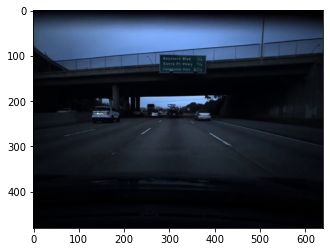

In [5]:
img = plt.imread('../input/speedchallengeframes/frames/frame00001.jpg')   # reading image using its name
plt.imshow(img)
print (img.shape)


In [6]:
#collect filenames if frames are already generated

import os

filenames = []
for root, dirs, files in os.walk('../input/speedchallengeframes/frames'):
    for file in files:
        if file.endswith('.jpg'):
            filenames.append(file)


In [7]:
filenames=np.asarray(sorted(filenames))
print(filenames)

['frame00000.jpg' 'frame00001.jpg' 'frame00002.jpg' ... 'frame20397.jpg'
 'frame20398.jpg' 'frame20399.jpg']


In [8]:
Y_train = np.loadtxt("../input/commaai-speed-challenge/data/train.txt")
print(Y_train)
files_labels=tuple(zip(sorted(filenames), Y_train))
print(files_labels)
#Y_train = np.asarray(Y_train).astype(np.float32)


#filenames_w_ylabels = [sorted(filenames), Y_train]
#df_filenames_ylabels = pd.DataFrame(filenames_w_ylabels).transpose()

#df_filenames_ylabels = df_filenames_ylabels.rename({0:'filename', 1:'class'}, axis='columns')

#print(df_filenames_ylabels)


[28.105569 28.105569 28.106527 ...  2.292917  2.2606    2.206759]
(('frame00000.jpg', 28.105569), ('frame00001.jpg', 28.105569), ('frame00002.jpg', 28.106527), ('frame00003.jpg', 28.130404), ('frame00004.jpg', 28.109243), ('frame00005.jpg', 28.088572), ('frame00006.jpg', 28.034211), ('frame00007.jpg', 28.018491), ('frame00008.jpg', 27.986624), ('frame00009.jpg', 28.016352), ('frame00010.jpg', 27.981986), ('frame00011.jpg', 27.978625), ('frame00012.jpg', 28.032331), ('frame00013.jpg', 27.960219), ('frame00014.jpg', 27.937178), ('frame00015.jpg', 27.940599), ('frame00016.jpg', 27.908579), ('frame00017.jpg', 27.898606), ('frame00018.jpg', 27.855982), ('frame00019.jpg', 27.795581), ('frame00020.jpg', 27.850634), ('frame00021.jpg', 27.839349), ('frame00022.jpg', 27.824348), ('frame00023.jpg', 27.759608), ('frame00024.jpg', 27.830055), ('frame00025.jpg', 27.761886), ('frame00026.jpg', 27.694763), ('frame00027.jpg', 27.761203), ('frame00028.jpg', 27.691932), ('frame00029.jpg', 27.666086), ('f

In [9]:
def get_batch_data(start, num_imgs, files_labels):
    begin=start
    end=start+num_imgs
    data_batch=files_labels[begin+1:end]
    im=image.load_img('../input/speedchallengeframes/frames/'+files_labels[begin][0])
    x1=np.expand_dims(image.img_to_array(im), axis=0)
    y=[]
    y.append(files_labels[begin][1])

    for file, label in enumerate(tqdm(data_batch)):
        im = image.load_img('../input/speedchallengeframes/frames/'+ label[0])
        im = np.expand_dims(image.img_to_array(im), axis=0)
        #print(im.shape)
        #print(x1.shape)
        #im = image.img_to_array(im)
        x1 = np.append(x1, im, axis=0)
        
        y.append(label[1])

    x2=np.delete(x1,0, axis=0)
    x1=np.delete(x1,-1, axis=0)
    y=np.delete(y, -1, axis=0)
    return x1,x2, np.asarray(y)

In [10]:
loss_history=[]
for i in range(30):
    X1_batch, X2_batch, Y_batch=get_batch_data(i*500, 500, files_labels)
    history=model.fit(x=(X1_batch,X2_batch), y=Y_batch, batch_size=32, epochs=20)
    print (i)
    print (i*500)
    del X1_batch
    del X2_batch
    gc.collect()
    

100%|██████████| 499/499 [02:58<00:00,  2.80it/s]


Epoch 1/20
16/16 [==============================] - 23s 1s/step - loss: 766.1703
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 314.8682
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 102.7385
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 72.6325
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 39.4627
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 19.6327
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 14.5442
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 10.5052
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 10.7167
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 8.3103
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 8.0081
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 6.0486
Epoch 13/20
16/16 [==================

100%|██████████| 499/499 [02:59<00:00,  2.78it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 71.4951
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 17.8257
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 7.0361
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 8.5452
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 4.3653
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 2.4465
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 1.6248
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 1.2712
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 1.1014
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.9769
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 0.8088
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 0.7401
Epoch 13/20
16/16 [============================

100%|██████████| 499/499 [03:02<00:00,  2.73it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 13.8187
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 6.1193
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 4.5830
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 4.0702
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 2.3484
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 2.0440
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 1.2932
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 0.9159
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 0.8136
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.4968
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 0.4070
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 0.3196
Epoch 13/20
16/16 [=============================

100%|██████████| 499/499 [02:59<00:00,  2.78it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 22.9750
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 9.1243
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 6.7769
Epoch 4/20
16/16 [==============================] - 20s 1s/step - loss: 3.9201
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 2.7490
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 2.4504
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 1.7044
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 1.1571
Epoch 9/20
16/16 [==============================] - 20s 1s/step - loss: 1.2847
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.9016
Epoch 11/20
16/16 [==============================] - 20s 1s/step - loss: 1.0618
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 1.0975
Epoch 13/20
16/16 [=============================

100%|██████████| 499/499 [03:03<00:00,  2.72it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 10.3154
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 7.7854
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 4.9766
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 3.5984
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 2.3255
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 1.7764
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 1.1146
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 1.1534
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 0.8245
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.7569
Epoch 11/20
16/16 [==============================] - 20s 1s/step - loss: 0.6820
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 0.5266
Epoch 13/20
16/16 [=============================

100%|██████████| 499/499 [03:04<00:00,  2.71it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 5.6793
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 2.9641
Epoch 3/20
16/16 [==============================] - 20s 1s/step - loss: 2.7945
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 2.4710
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 2.4132
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 1.0781
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 0.8471
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 0.5175
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 0.4943
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.6015
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 0.9993
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 0.5040
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:02<00:00,  2.74it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 4.1935
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 2.3078
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 1.6843
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 0.9435
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 0.7671
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 0.4824
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 0.4115
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 0.8082
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 0.5002
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.3494
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 0.3319
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 0.1768
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:02<00:00,  2.74it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 3.3678
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 2.6838
Epoch 3/20
16/16 [==============================] - 20s 1s/step - loss: 3.7524
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 2.5405
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 1.4285
Epoch 6/20
16/16 [==============================] - 20s 1s/step - loss: 0.7632
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 0.4713
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 0.6826
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 0.9571
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.5887
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 0.3716
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 0.3369
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:02<00:00,  2.73it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 1.9993
Epoch 2/20
16/16 [==============================] - 20s 1s/step - loss: 1.7203
Epoch 3/20
16/16 [==============================] - 20s 1s/step - loss: 1.6232
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 0.8449
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 0.8411
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 0.9003
Epoch 7/20
16/16 [==============================] - 20s 1s/step - loss: 0.6327
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 0.4315
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 0.2845
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 0.1944
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 0.1811
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 0.1849
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:00<00:00,  2.77it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 19.1477
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 3177.3665
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 119767.6797
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 80312.8750
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 215067.7031
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 682.8690
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 426.1722
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 472.6060
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 470.4868
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 468.3022
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 466.1969
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 464.2667
Epoch 13/20
16/16

100%|██████████| 499/499 [03:00<00:00,  2.77it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 505.3740
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 503.9341
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 502.4909
Epoch 4/20
16/16 [==============================] - 20s 1s/step - loss: 501.0515
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 499.6176
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 498.1900
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 496.7675
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 495.3510
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 493.9391
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 492.5327
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 491.1302
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 489.7342
Epoch 13/20
16/16 [======

100%|██████████| 499/499 [03:00<00:00,  2.77it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 4682.0312
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 367.5638
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 367.5020
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 366.4823
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 365.4637
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 364.4388
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 363.4150
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 362.3963
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 361.3704
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 360.3441
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 359.3252
Epoch 12/20
16/16 [==============================] - 20s 1s/step - loss: 358.3010
Epoch 13/20
16/16 [=====

100%|██████████| 499/499 [03:01<00:00,  2.76it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 117.7702
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 117.3564
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 116.9884
Epoch 4/20
16/16 [==============================] - 20s 1s/step - loss: 116.6286
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 116.2685
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 115.9085
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 115.5469
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 115.1846
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 114.8208
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 114.4555
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 114.0890
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 113.7218
Epoch 13/20
16/16 [======

100%|██████████| 499/499 [03:02<00:00,  2.74it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 181.7464
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 181.1646
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 180.5556
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 179.9410
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 179.3248
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 178.7080
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 178.0894
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 177.4703
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 176.8516
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 176.2284
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 175.6079
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 174.9850
Epoch 13/20
16/16 [======

100%|██████████| 499/499 [03:01<00:00,  2.75it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 278.8333
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 277.8305
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 276.7835
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 275.7266
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 274.6722
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 273.6164
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 272.5614
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 271.5073
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 270.4558
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 269.4044
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 268.3546
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 267.3043
Epoch 13/20
16/16 [======

100%|██████████| 499/499 [03:02<00:00,  2.73it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 422.3959
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 420.7701
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 419.0786
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 417.3784
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 415.6829
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 413.9909
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 412.3050
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 410.6236
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 408.9470
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 407.2747
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 405.6068
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 403.9427
Epoch 13/20
16/16 [======

100%|██████████| 499/499 [03:01<00:00,  2.75it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 383.0857
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 381.4959
Epoch 3/20
16/16 [==============================] - 20s 1s/step - loss: 379.9102
Epoch 4/20
16/16 [==============================] - 20s 1s/step - loss: 378.3249
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 376.7447
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 375.1632
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 373.5841
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 372.0063
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 370.4261
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 368.8511
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 367.2788
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 365.7008
Epoch 13/20
16/16 [======

100%|██████████| 499/499 [03:02<00:00,  2.74it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 44.5096
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 44.2328
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 44.0251
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 43.8302
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 43.6363
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 43.4423
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 43.2480
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 43.0532
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 42.8567
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 42.6602
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 42.4633
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 42.2652
Epoch 13/20
16/16 [==================

100%|██████████| 499/499 [03:00<00:00,  2.77it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 16.5901
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 16.5755
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 16.5658
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 16.5584
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 16.5503
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 16.5421
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 16.5350
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 16.5269
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 16.5193
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 16.5113
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 16.5036
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 16.4955
Epoch 13/20
16/16 [==================

100%|██████████| 499/499 [03:00<00:00,  2.77it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 7.9814
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 7.9402
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 7.8932
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 7.8454
Epoch 5/20
16/16 [==============================] - 20s 1s/step - loss: 7.7969
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 7.7485
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 7.6999
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 7.6513
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 7.6027
Epoch 10/20
16/16 [==============================] - 20s 1s/step - loss: 7.5537
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 7.5051
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 7.4560
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:01<00:00,  2.75it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 3.7706
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 3.7617
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 3.7551
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 3.7492
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 3.7427
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 3.7367
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 3.7310
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 3.7247
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 3.7187
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 3.7126
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 3.7067
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 3.7005
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:00<00:00,  2.76it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 5.8986
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 5.8940
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 5.8862
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 5.8783
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 5.8702
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 5.8624
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 5.8539
Epoch 8/20
16/16 [==============================] - 20s 1s/step - loss: 5.8462
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 5.8377
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 5.8301
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 5.8216
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 5.8142
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:00<00:00,  2.76it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 3.6647
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 3.6554
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 3.6461
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 3.6369
Epoch 5/20
16/16 [==============================] - 20s 1s/step - loss: 3.6279
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 3.6182
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 3.6095
Epoch 8/20
16/16 [==============================] - 20s 1s/step - loss: 3.6003
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 3.5911
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 3.5822
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 3.5730
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 3.5639
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:01<00:00,  2.76it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 3.2205
Epoch 2/20
16/16 [==============================] - 20s 1s/step - loss: 3.2034
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 3.1777
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 3.1511
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 3.1240
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 3.0971
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 3.0699
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 3.0432
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 3.0170
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 2.9902
Epoch 11/20
16/16 [==============================] - 20s 1s/step - loss: 2.9641
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 2.9377
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:01<00:00,  2.76it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 7.7751
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 7.7229
Epoch 3/20
16/16 [==============================] - 20s 1s/step - loss: 7.6662
Epoch 4/20
16/16 [==============================] - 20s 1s/step - loss: 7.6115
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 7.5548
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 7.4996
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 7.4442
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 7.3888
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 7.3338
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 7.2800
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 7.2256
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 7.1730
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:01<00:00,  2.74it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 12.3922
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 12.3142
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 12.2336
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 12.1520
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 12.0725
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 11.9924
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 11.9136
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 11.8361
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 11.7580
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 11.6828
Epoch 11/20
16/16 [==============================] - 20s 1s/step - loss: 11.6062
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 11.5325
Epoch 13/20
16/16 [==================

100%|██████████| 499/499 [03:01<00:00,  2.75it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 10.4011
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 10.3664
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 10.3079
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 10.2452
Epoch 5/20
16/16 [==============================] - 20s 1s/step - loss: 10.1825
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 10.1182
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 10.0591
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 9.9971
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 9.9376
Epoch 10/20
16/16 [==============================] - 20s 1s/step - loss: 9.8793
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 9.8214
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 9.7643
Epoch 13/20
16/16 [=======================

100%|██████████| 499/499 [03:02<00:00,  2.73it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 15.5214
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 15.5170
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 15.5075
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 15.4966
Epoch 5/20
16/16 [==============================] - 19s 1s/step - loss: 15.4860
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 15.4758
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 15.4654
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 15.4551
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 15.4455
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 15.4372
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 15.4265
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 15.4185
Epoch 13/20
16/16 [==================

100%|██████████| 499/499 [03:01<00:00,  2.75it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 6.6410
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 6.5528
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 6.4361
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 6.3183
Epoch 5/20
16/16 [==============================] - 20s 1s/step - loss: 6.2005
Epoch 6/20
16/16 [==============================] - 20s 1s/step - loss: 6.0861
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 5.9746
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 5.8658
Epoch 9/20
16/16 [==============================] - 19s 1s/step - loss: 5.7589
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 5.6551
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 5.5540
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 5.4554
Epoch 13/20
16/16 [==============================

100%|██████████| 499/499 [03:02<00:00,  2.73it/s]


Epoch 1/20
16/16 [==============================] - 19s 1s/step - loss: 35.1471
Epoch 2/20
16/16 [==============================] - 19s 1s/step - loss: 35.1482
Epoch 3/20
16/16 [==============================] - 19s 1s/step - loss: 35.1480
Epoch 4/20
16/16 [==============================] - 19s 1s/step - loss: 35.1482
Epoch 5/20
16/16 [==============================] - 20s 1s/step - loss: 35.1480
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 35.1482
Epoch 7/20
16/16 [==============================] - 19s 1s/step - loss: 35.1480
Epoch 8/20
16/16 [==============================] - 19s 1s/step - loss: 35.1478
Epoch 9/20
16/16 [==============================] - 20s 1s/step - loss: 35.1479
Epoch 10/20
16/16 [==============================] - 19s 1s/step - loss: 35.1489
Epoch 11/20
16/16 [==============================] - 19s 1s/step - loss: 35.1479
Epoch 12/20
16/16 [==============================] - 19s 1s/step - loss: 35.1480
Epoch 13/20
16/16 [==================

In [2]:

model.save('siamese_model') 

X1_batch, X2_batch, Y_batch=get_batch_data(16000, 4000, files_labels)
result=model.evaluate(x=(X1_batch,X2_batch), y=Y_batch, batch_size=32)
print(result)

ModuleNotFoundError: No module named 'tensorflow.keras.models.save_model'